In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam




## Function for  Filtering 

In [2]:
from scipy.signal import butter, lfilter

def butter_bandpass(data,lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

## Generate the Training Data Set 

In [3]:
np.random.seed(13)
nsamp=500000
thk_min=3    # Minimum thickness measured in samples (dt=1 ms)
thk_mode=5   # modal thickness
thk_max=10   # max thickness
fhcut=80     # high cut for feature vector
flcut=8      # low cut for feature vector
lhcut=300    # high cut for label vector
llcut=3      # low cut for label vector
fs=1000      # sampling freq ---> 1 ms


## define impedance list
impval=np.array(np.linspace(4000,12000,17))
imp=np.random.choice(impval,nsamp)
layer_thickness=np.fix(np.random.triangular(thk_min,thk_mode,thk_max,nsamp))
thk_prof=np.cumsum(layer_thickness)

ref=np.zeros(3000000)
##calculate reflectivity series ---> ref=(z2-z1)/(z2+z1)
for ii in range(nsamp-1):
    ref_temp=(imp[ii+1]-imp[ii])/(imp[ii+1]+imp[ii])
    ref[int(thk_prof[ii])]=ref_temp
    
# Generate the seismic data high resolution pair
seismic=butter_bandpass(ref,flcut, fhcut, fs, order=5)
labels=butter_bandpass(ref,llcut, lhcut, fs, order=5)

## Plot the Data

Text(0.5, 0, 'amp')

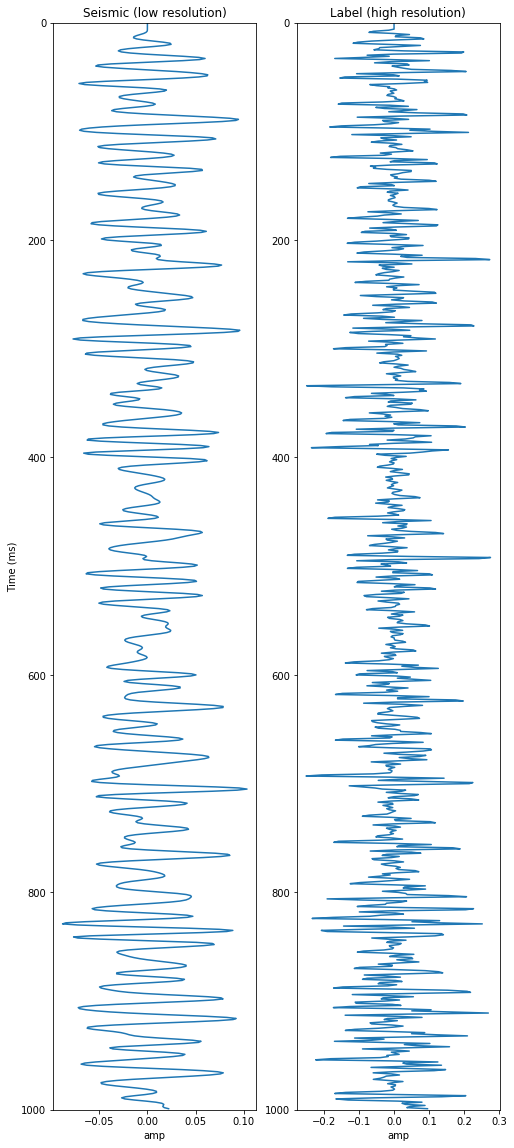

In [4]:
# Plot the data

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(8, 20)) 
ax1.plot(seismic[0:1000], np.array(range(1000)))
ax1.set_title('Seismic (low resolution)')
ax1.set_ylim((0,1000)[::-1])
ax1.set_ylabel('Time (ms)')
ax1.set_xlabel('amp')
ax2.plot(labels[0:1000], np.array(range(1000)))
ax2.set_title('Label (high resolution)')
ax2.set_ylim((0,1000)[::-1])
ax2.set_xlabel('amp')


## Split and Format Data 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(seismic, labels, test_size=0.25, random_state=42)


In [6]:
x_train=np.reshape(X_train,(4500,500))
x_test=np.reshape(X_test,(1500,500))
y_train=np.reshape(y_train,(4500,500))
y_test=np.reshape(y_test,(1500,500))

x_train=np.expand_dims(x_train, axis=-1)
y_train=np.expand_dims(y_train, axis=-1)
x_train=np.expand_dims(x_train, axis=-1)
y_train=np.expand_dims(y_train, axis=-1)

In [7]:
x_train.shape

(4500, 500, 1, 1)

## Import Ancilliary Functions

In [8]:
sys.path.append(r'E:/PythEnv')
from resnet_model import resnet_v1
from schedule_lr import lr_schedule
from unet_model import UNet



## Build the ResNet model 

In [9]:
DEPTH=20
batch_size=500
epochs=10
nrow,ncol,c1,c2=x_train.shape
input_shape=(ncol,c1,c2)

model = resnet_v1(input_shape=input_shape, depth=DEPTH,num_classes=ncol)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 1, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 500, 1, 16)   64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 500, 1, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 500, 1, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Compile and Run 

In [10]:

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

model.compile(loss='mean_squared_error',optimizer=Adam(lr=lr_schedule(0)), metrics=["mean_squared_error"])

model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,verbose=2,shuffle=True,initial_epoch=0)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Learning rate:  0.001
Train on 4050 samples, validate on 450 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[500,500,500,500] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node loss/dense_loss/SquaredDifference}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
